In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import cvxpy as cp

class SyntheticControl(BaseEstimator, RegressorMixin):

    def __init__(self,):
        pass

    def fit(self, y_pre_co, y_pre_tr):

        y_pre_co, y_pre_tr = check_X_y(y_pre_co, y_pre_tr)
    
        w = cp.Variable(y_pre_co.shape[1])
        
        objective = cp.Minimize(cp.sum_squares(y_pre_co@w - y_pre_tr))
        constraints = [cp.sum(w) == 1, w >= 0]
        
        problem = cp.Problem(objective, constraints)
        
        self.loss_ = problem.solve(verbose=False)
        self.w_ = w.value
        
        self.is_fitted_ = True
        return self
        
        
    def predict(self, y_co):

        check_is_fitted(self)
        y_co = check_array(y_co)
        
        return y_co @ self.w_

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/smoking.csv")

In [4]:
df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california,after_treatment
0,1,1970,89.800003,NaN,NaN,0.178862,39.599998,False,False
1,1,1971,95.400002,NaN,NaN,0.179928,42.700001,False,False
2,1,1972,101.099998,9.498476,NaN,0.180994,42.299999,False,False
3,1,1973,102.900002,9.550107,NaN,0.182060,42.099998,False,False
4,1,1974,108.199997,9.537163,NaN,0.183126,43.099998,False,False


# Canonical Synthetic Control

In [5]:
y_pre_co = df.query("~california & year < 1988").pivot("year", "state", "cigsale")
y_pre_tr = df.query("california & year < 1988").pivot("year", "state", "cigsale")
y_post_co = df.query("~california & year >= 1988").pivot("year", "state", "cigsale")
y_post_tr = df.query("california & year >= 1988").pivot("year", "state", "cigsale")

(y_pre_co.shape, y_pre_tr.shape, y_post_co.shape, y_post_tr.shape)

((18, 38), (18, 1), (13, 38), (13, 1))

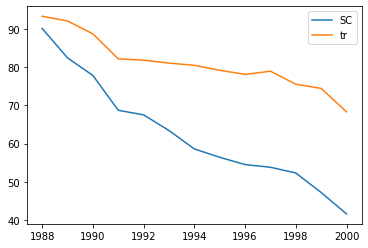

In [6]:
sc_canonical = SyntheticControl()
sc_canonical.fit(y_pre_co=y_pre_co, y_pre_tr=y_pre_tr.mean(axis=1))

plt.plot(y_post_tr.index, y_post_tr, label="SC")
plt.plot(y_post_tr.index, sc_canonical.predict(y_post_co), label="tr")
plt.legend();

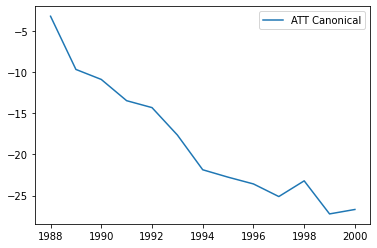

In [7]:
att_canonical = y_post_tr.mean(axis=1) - sc_canonical.predict(y_post_co)

plt.plot(y_post_tr.index, att_canonical, label="ATT Canonical")
plt.legend();

# Bias of Synthetic Control

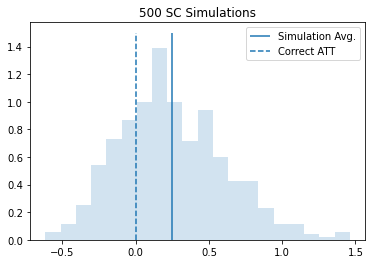

In [8]:
from statsmodels.tsa.arima_process import ArmaProcess

def sim_sc_data(N=16, T0=15, T1=28):
    Y_co = np.random.normal(
        np.array([np.concatenate([np.ones(3), np.zeros(N-3)])*2 for _ in range(T0+T1)])
    )
    
    w = np.concatenate([np.ones(3), np.zeros(N-3)])*1/3
    Y_tr = Y_co.dot(w) + ArmaProcess(0.8).generate_sample(T0+T1)
    
    model = SyntheticControl().fit(
        y_pre_co=Y_co[:T0],
        y_pre_tr=Y_tr[:T0].flatten()
    )
        
    return (Y_tr[T0:].flatten() - model.predict(Y_co[T0:])).mean()


np.random.seed(123)

atts = [sim_sc_data() for _ in range(500)]

plt.hist(atts, alpha=0.2, density=True, bins=20)
plt.vlines(np.mean(atts), 0, 1.5, label="Simulation Avg.")
plt.vlines(0, 0, 1.5, label="Correct ATT", ls="dashed")
plt.title("500 SC Simulations")
plt.legend();


# Debiasing Synthetic Control

In [9]:
def debiased_sc_atts(y_pre_co, y_pre_tr, y_post_co, y_post_tr, K=3):
        
    block_size = int(min(np.floor(len(y_pre_tr)/K), len(y_post_tr)))
    blocks = np.split(y_pre_tr.index[-K*block_size:], K)
    
    def fold_effect(hold_out):
        model = SyntheticControl()
        model.fit(
            y_pre_co.drop(hold_out),
            y_pre_tr.drop(hold_out)
        )
        
        bias_hat = np.mean(y_pre_tr.loc[hold_out]
                           - model.predict(y_pre_co.loc[hold_out]))
        
        y0_hat = model.predict(y_post_co)
        return (y_post_tr - y0_hat) - bias_hat
    
    
    return pd.DataFrame([fold_effect(block) for block in blocks]).T

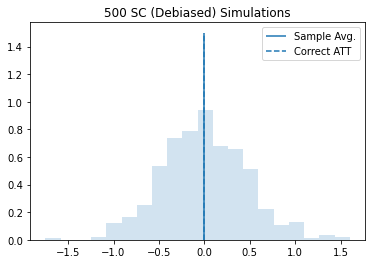

In [10]:
def sim_deb_sc_data(N=16, T0=15, T1=28):
    Y_co = np.random.normal(
        np.array([np.concatenate([np.ones(3), np.zeros(N-3)])*2 for _ in range(T0+T1)])
    )
    
    w = np.concatenate([np.ones(3), np.zeros(N-3)])*1/3
    Y_tr = Y_co.dot(w) + ArmaProcess(0.8).generate_sample(T0+T1)
    
    df_co = pd.DataFrame(Y_co)
    df_tr = pd.DataFrame(Y_tr)
    
    atts = debiased_sc_atts(df_co.iloc[:T0],
                            df_tr.iloc[:T0].mean(axis=1),
                            df_co.iloc[T0:],
                            df_tr.iloc[T0:].mean(axis=1), K=2)
    
        
    return atts.mean(axis=0).mean()


np.random.seed(123)
atts = [sim_deb_sc_data() for _ in range(500)]

plt.hist(atts, alpha=0.2, density=True, bins=20)
plt.vlines(np.mean(atts), 0, 1.5, label="Sample Avg.")
plt.vlines(0, 0, 1.5, label="Correct ATT", ls="dashed")
plt.title("500 SC (Debiased) Simulations")
plt.legend();


In [11]:
deb_atts = debiased_sc_atts(y_pre_co,
                            y_pre_tr.mean(axis=1),
                            y_post_co,
                            y_post_tr.mean(axis=1),
                            K=3)

deb_atts.head()

,0,1,2
year,,,
1988,-4.409436,-2.443765,-5.990111
1989,-9.894050,-8.927084,-11.670736
1990,-12.472751,-10.043103,-12.025641
1991,-19.098965,-12.790990,-13.049163
1992,-20.560079,-13.713525,-12.055487


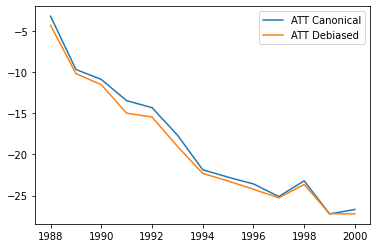

In [12]:
plt.plot(y_post_tr.index, att_canonical, label="ATT Canonical")
plt.plot(y_post_tr.index, deb_atts.mean(axis=1), label="ATT Debiased")
plt.legend();

## Inference

In [13]:
atts_k = deb_atts.mean(axis=0).values
att = np.mean(atts_k)

print("atts_k:", atts_k)
print("ATT:", att)

atts_k: [-22.86374666 -17.92785158 -16.55263775]
ATT: -19.11474533071647


In [14]:
K = len(atts_k)
T0 = len(y_pre_co)
T1 = len(y_post_co)
block_size = min(np.floor(T0/K), T1)

se_hat = np.sqrt(1+((K*block_size)/T1))*np.std(atts_k, ddof=1)/np.sqrt(K)

print("SE:", se_hat)

SE: 2.958845526031049


In [15]:
from scipy.stats import t
alpha = 0.1

[att - t.ppf(1-alpha/2, K-1)*se_hat,
 att + t.ppf(1-alpha/2, K-1)*se_hat]

[-27.754531601226567, -10.474959060206375]